I'm tempted to prompt for the dataloader code

I'll likely be using PyTorch alot though so manually getting aquainted with the pytorch interfaces is a better approach

## Goals
1. Understand datasets and dataloaders
2. I think mnist is available through pytorch (other examples?) -> YES. https://pytorch.org/vision/stable/datasets.html
3. torchvision for images. Aren't images just tensors/matrices?
4. Data Preparation -> data splitting, train/val/test, batching
5. Normalization / standardization <- Maybe defer this till later

# Datasets
A Dataset in PyTorch represents your data.
It's an abstract class that you can subclass to create custom datasets.
Each Dataset must implement len (returns the size of the dataset) and getitem (returns a sample from the dataset).
Datasets handle how individual data points are accessed and preprocessed.

# Dataloaders
DataLoaders wrap an iterable around the Dataset to enable easy access to samples.
They handle batching, shuffling, multiprocessing for loading data, and other important features.
DataLoaders are particularly useful for:
Batching data
Shuffling data
Loading data in parallel using multiprocessing workers
Automatically sending data to the correct device (CPU/GPU)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset
from torchvision import datasets, transforms 

import numpy as np
import matplotlib.pyplot as plt

In [16]:
from lib.plot import plot_mnist_sample

In [17]:
train_mnist = datasets.MNIST('./data', train=True, download=True)
test_mnist = datasets.MNIST('./data', train=False, download=True)

In [18]:
print(isinstance(train_mnist, Dataset))

True


In [19]:
train_mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [20]:
test_mnist

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [21]:
img, label = train_mnist[0]
type(img)

PIL.Image.Image

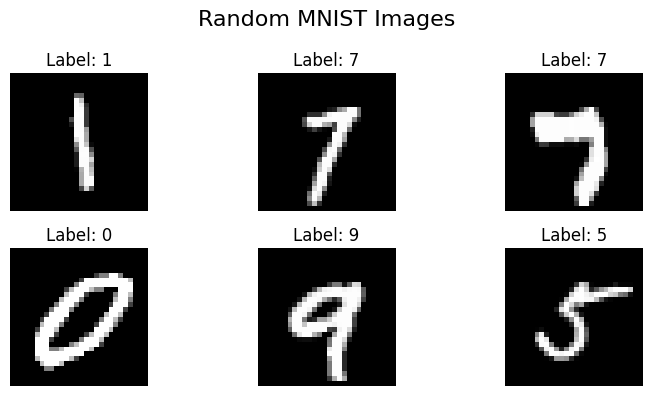

In [22]:
plot_mnist_sample(train_mnist)

# Combine and Transform

Pytorch MNIST set contains train/test for classification. We need a train set containing all `0`'s (the normal class) and a test set containing `0`s and an artificially small subset of digits `1-9` (the anomaly class)

Thus we combine the test/train mnist sets and make a custom split.

Also we transorm the PIL images from the set to tensors for training. Transforms come from the `tochvision` package used primarily for PIL-Image/Tensor to PIL-Image/Tensor transformations on dataset 


In [23]:
mnist = ConcatDataset([train_mnist, test_mnist]) 

# Test/Train Split

The mnist dataset is preconfigured for digit classification test/train split.

We need a custom split for anomaly detection. 

Many ways to accomplish this -- for now we assign

1) 0 - normal class
2) 1-9 - anomaly class

Roughly 7000 occurrences of `0` in the combined test + train mnist set. 

Most of these (~80 % = 5600) designated for custom train set. Anomalies not included in test for most unsupervised approaches. 

The remaing `0`s, say ~1400, go in the test set along with a small fraction (maybe 100 based on analysis below) of `1-0` anomalies. 

# Best Practices for Anomaly Detection Test Set Composition

Realistic Anomaly Rate:

Aim to reflect the expected real-world anomaly rate in your test set.
Typical anomaly rates in practice range from 1% to 10%, rarely exceeding 20%.

In [24]:
len(mnist)

70000

In [25]:
normal_labels = [0]

normal_indices = [i for i, (_, label) in enumerate(mnist) if label in normal_labels]
anomaly_indices = [i for i, (_, label) in enumerate(mnist) if label not in normal_labels]
len(normal_indices) + len(anomaly_indices)

70000

In [26]:
normal = Subset(mnist, normal_indices)
anomaly = Subset(mnist, anomaly_indices)

# Test / Train split

Why do we use test/train split? 

Answer:
We want to train models that generalize (extrapolate) well to new data.  \
Testing a model on unseen data can prevent overfitting at the small cost of a smaller training set \

# What about Train/Validation/Test
Sometimes referred to as train/dev/test

This approach introduces a 'validation' pentultimate dataset for
1. Model evaluation
2. Hyperparameter Tuning
3. Optimal stopping and overfitting prevention

Then the test set acts as a 'real world' evaluation.

# Cross Validation
Another technique used to balance training efficiency with overfitting prevention. \
K-fold cross validation: Split data into k subsets. Train on k-1, test on 1. Repeat k times, rotating test set. Average performance across iterations.

In [30]:
'''
Let's start with a simple test train split to start

We have 
- 6903 normal (0)
- 63097 anomaly (1-9)

Need
- ~20% test (0, 1-9)
    - ~10% (1-9)
    - ~90% (0)
- ~80% train (0)

Some algebra - We have 6903 (0) at a ratio of 80:(.9*20) = 80:18
=> 80/98 * 6903 ~= 5635 train (0)
=> 6903 - 5635 = 1268 test (0)

=> 1/9 * 1268 ~= 140 test (1-9)

Final results
Train:
    - 5635 (0)

Test 
    - 1268 (0)
    - 140 (1-9)

'''

"\nLet's start with a simple test train split to start\n\nWe have \n- 6903 normal (0)\n- 63097 anomaly (1-9)\n\nNeed\n- ~20% test (0, 1-9)\n    - ~10% (1-9)\n    - ~90% (0)\n- ~80% train (0)\n\nSome algebra - We have 6903 (0) at a ratio of 80:(.9*20) = 80:18\n=> 80/98 * 6903 ~= 5635 train (0)\n=> 6903 - 5635 = 1268 test (0)\n\n=> 1/9 * 1268 ~= 140 test (1-9)\n\nFinal results\nTrain:\n    - 5635 (0)\n\nTest \n    - 1268 (0)\n    - 140 (1-9)\n\n"

In [29]:
len(normal)

6903